In [2]:
from numba import cuda

# Select GPU 2
cuda.select_device(3)

# Now all subsequent operations will run on GPU 2


<weakproxy at 0x7f65153fa360 to Device at 0x7f6515472850>

In [2]:
import pandas as pd

#Read files in
# File paths
file_path1 = "Sample.spatial.csv.gz"

# Read the files
df = pd.read_csv(file_path1, compression='gzip')
df.columns = ["Bead1_seq", "UMI", "Bead2_seq"]



import pandas as pd

def bead1_bead2_interaction(input_df):
    # Rename columns
    inside_df = input_df.copy()
    inside_df.columns = ["Bead1_seq", "UMI", "Bead2_seq"]

    # Group by Bead1_seq and Bead2_seq, then count unique UMI values
    n_umi_per_interaction_table = inside_df.groupby(['Bead1_seq', 'Bead2_seq']).size().reset_index(name='n_umi')

    # Group by Bead1_seq and count unique UMI values
    n_umi_per_bead1_table = n_umi_per_interaction_table.groupby('Bead1_seq').size().reset_index(name='n_umi')

    return {'n_umi_per_interaction': n_umi_per_interaction_table,
            'n_umi_per_bead1': n_umi_per_bead1_table}




In [ ]:
output_list_patterns_Filter = bead1_bead2_interaction(df)


In [8]:
import numpy as np

# Assuming output_list_patterns_Filter is a dictionary and n_umi_per_interaction is a key pointing to a DataFrame
output_list_patterns_Filter['n_umi_per_interaction']['log_transformed'] = np.log10(output_list_patterns_Filter['n_umi_per_interaction']['n_umi'])


In [9]:
# Filter low quality interactions
filtered_df_filter = output_list_patterns_Filter['n_umi_per_interaction'][output_list_patterns_Filter['n_umi_per_interaction']['log_transformed'] >= .2]


In [ ]:
n_umi_range = filtered_df_filter['n_umi'].agg(['min', 'max'])

print("Range of n_umi column:")
print(f"Min: {n_umi_range['min']}")

print(f"Max: {n_umi_range['max']}")



In [11]:
import pandas as pd
import numpy as np
from scipy.sparse import lil_matrix

# Extract unique values
unique_bead1_seq = filtered_df_filter['Bead1_seq'].unique()
unique_bead2_seq = filtered_df_filter['Bead2_seq'].unique()

# Create mappings from sequences to indices
bead1_index = {seq: idx for idx, seq in enumerate(unique_bead1_seq)}
bead2_index = {seq: idx for idx, seq in enumerate(unique_bead2_seq)}

# Get the number of unique values
num_bead1_seq = len(unique_bead1_seq)
num_bead2_seq = len(unique_bead2_seq)

# Create a sparse matrix initialized with zeros (lil_matrix for easy assignment)
matrix_data_filter_sparse = lil_matrix((num_bead1_seq, num_bead2_seq), dtype=np.int64)

# Fill the sparse matrix with counts from the original DataFrame
for _, row in filtered_df_filter.iterrows():
    row_index1 = bead1_index[row['Bead1_seq']]
    row_index2 = bead2_index[row['Bead2_seq']]
    matrix_data_filter_sparse[row_index1, row_index2] = row['n_umi']

# Convert to csr_matrix after filling
matrix_data_filter_sparse = matrix_data_filter_sparse.tocsr()



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/ru-auth/local/home/aabdul/miniconda3/envs/cell2loc_env2/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


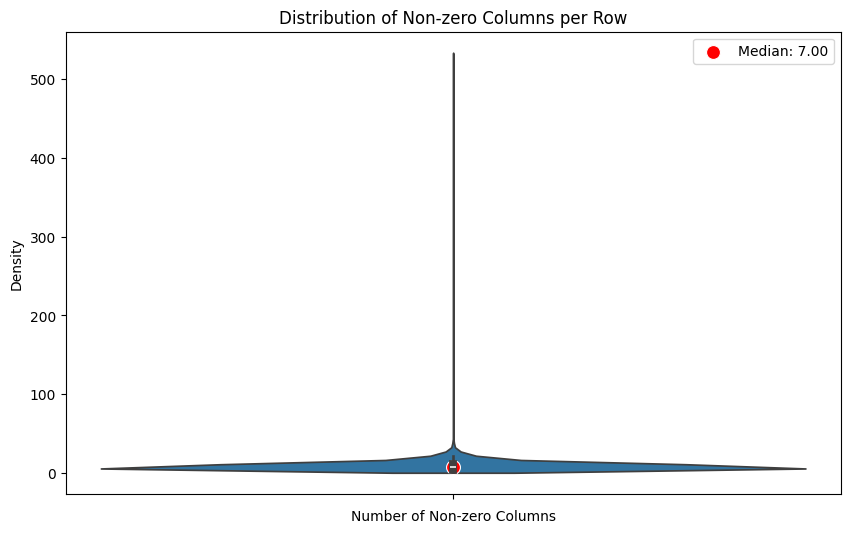

In [13]:
#Plot unique sender beads per receiver bead
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Assuming 'matrix_data_filter_sparse' is a sparse matrix in CSR format
# Calculate the number of non-zero columns for each row (use getnnz to count non-zero elements in each row)
non_zero_counts = np.array(matrix_data_filter_sparse.getnnz(axis=1))

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'NonZeroCounts': non_zero_counts})

# Calculate the median value
median_value = plot_df['NonZeroCounts'].median()

# Plotting the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(y=plot_df['NonZeroCounts'])

# Plot the median value as a point
sns.scatterplot(x=[0], y=[median_value], color='red', s=100, marker='o', label=f'Median: {median_value:.2f}')

# Add labels and title
plt.xlabel('Number of Non-zero Columns')
plt.ylabel('Density')
plt.title('Distribution of Non-zero Columns per Row')
plt.legend()

# Save the plot as a PDF file
plt.savefig('violin_plot.pdf')  # Make sure the path is correct and accessible

# Show the plot
plt.show()


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

# Assuming 'matrix_data_filter_sparse' is in CSR format

# Log1p transformation applied only to non-zero elements (sparse-compatible)
matrix_data_log1p = matrix_data_filter_sparse.copy()
matrix_data_log1p.data = np.log1p(matrix_data_log1p.data)

# Standardize the data (subtract mean and divide by std) in a sparse-aware manner
#scaler = StandardScaler(with_mean=False)  # Set `with_mean=False` because centering sparse data would make it dense
#matrix_data_standardized = scaler.fit_transform(matrix_data_log1p)

# Use TruncatedSVD for dimensionality reduction (sparse PCA alternative)
svd = TruncatedSVD(n_components=7000)  # Choose a suitable number of components
matrix_data_pca = svd.fit_transform(matrix_data_log1p)


In [ ]:
import numpy as np

# Save as .npy file
np.save('matrix_data_pca.npy', matrix_data_pca)



In [3]:


# Load the .npy file
matrix_data_pca = np.load('matrix_data_pca.npy')


In [57]:
#Save beads IDs 
# Save to a text file
np.savetxt('unique_bead1_seq.txt', unique_bead1_seq, fmt='%s')


In [ ]:
import cudf
import cuml

# Assuming 'matrix_data_pca' is a NumPy array or pandas DataFrame, convert it to cuDF DataFrame
# For best performance, it's recommended to have your data initially loaded directly to GPU if possible
#gpu_matrix_data_pca = cudf.DataFrame(matrix_data_pca)

# Set the random seed for reproducibility
SEED = 42

# Create and fit the UMAP transformer using cuML
mapper = cuml.UMAP(
    n_neighbors=70,
    min_dist=.65,
    metric='cosine',
    random_state=SEED,
    n_epochs=700000,
    verbose=True)

coords = mapper.fit_transform(matrix_data_pca)



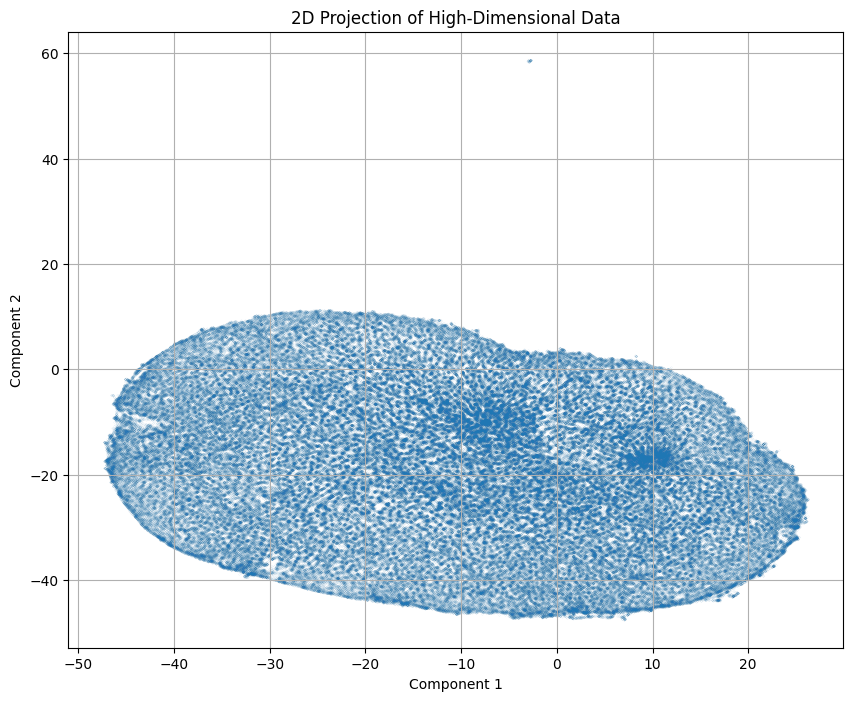

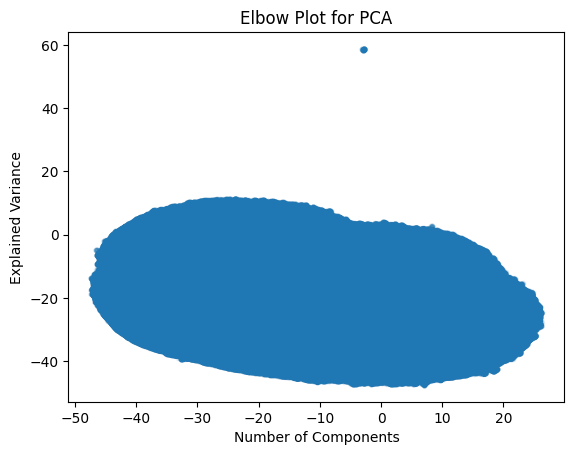

In [26]:
import matplotlib.pyplot as plt



x = coords[:, 0]  # First column corresponds to umap1
y = coords[:, 1]  # Second column corresponds to umap2


plt.figure(figsize=(10, 8))  # Set the figure size
plt.scatter(x, y, alpha=1, s=.001)  # Create a scatter plot
plt.title('2D Projection of High-Dimensional Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()




# Save the plot as a PDF file
plt.scatter(x, y, alpha=0.1, s=10)  # Create a scatter plot

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Elbow Plot for PCA')
# Save the plot as a PDF file
plt.savefig('UMAP_map.pdf')  # Make sure the path is correct and accessible



In [ ]:
x = coords[:, 0]  # First column corresponds to umap1
y = coords[:, 1]  # Second column corresponds to umap2
umap_df = pd.DataFrame({'UMAP1': x, 'UMAP2': y}, index=unique_bead1_seq)


In [ ]:


#FO1_2
# Specify your desired file path and name
file_path = "/coords.csv"

# Save the DataFrame to a CSV file
umap_df.to_csv(file_path)

# Optionally print a message to indicate the process is done
print(f"Data saved to {file_path}")

